In [1]:
import curr_adventure as cad 
import jax.numpy as jnp
from jax import random as jrandom
from jax import jit, partial, grad, jacfwd, jacrev
import numpy as np


from curr_adventure.derivative_estimation.one_E_zero import SD_1E0
from curr_adventure.derivative_estimation.grid_generation import generate_ellipse


from utils import run_tests, mse_loss

from scipy.stats import linregress
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

from jax.config import config
config.update("jax_enable_x64", True)

import itertools 

%load_ext autoreload

%autoreload 2

In [32]:
def simplex_gradient(F, x_0, S, subkey_f):
    jrandom_key, subkey = jrandom.split(subkey_f)
    FS = F.f(S.T + x_0, subkey)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    F_x_0 = F.f(x_0.reshape(1, -1), subkey)
    SS_inv = jnp.linalg.inv(S.dot(S.T))
    return SS_inv.dot(S.dot(FS - F_x_0))


class Ackley:
    def __init__(self, sig=0):
        if sig is None:
            sig = 0
        self.sig = sig

        self._f1 = grad(lambda x: self.f(x, None)[0])
        self._f2 = jacfwd(lambda x: self.f1(x))
    
    def f(self, X, jrandom_key=None):
        xs = X.T
        out_shape = xs[0].shape
        a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        b = - jnp.exp(1. / len(xs) *jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        out = jnp.array(-20 * a + b + 20 + jnp.exp(1)).reshape(out_shape)
        if jrandom_key is not None:
            return out + self.sig * jrandom.normal(jrandom_key, shape=(X.shape[0], )) 
        return out


    def f1(self, X):
        """del H/del xi = -20 * -0.2 * (xi * 1/n) / sqrt(1/n sum_j xj^2) * a + 2 pi sin(2 pi xi)/n * b"""
        # xs = X.T
        # out_shape = xs.shape
        # a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        # b = -jnp.exp(1. / len(xs) * jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        # a_p = -0.2 * (xs * 1. / len(xs)) / jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0)))
        # b_p = -2 * jnp.pi * jnp.sin(2 * jnp.pi * xs) / len(xs)
        # grad = jnp.nan_to_num(
        #     -20 * a_p * a + b_p * b).reshape(out_shape)  # only when norm(x) == 0 do we have nan and we know the grad is zero there
        # grad = grad.T
        
        # return grad
        return self._f1(X.reshape(1, -1))[0]

    def f2(self, X):
        # return jacfwd(lambda x: self.f1(x))(X).reshape(X.shape[0], X.shape[1], X.shape[1])
        return self._f2(X.reshape(1, -1)).reshape(X.size, X.size)

class Quadratic:
    def __init__(self, Q, b, sig=0):
        self.Q = Q
        self.b = b
        self.sig = sig
        self._f1 = grad(lambda x: self.f(x, None)[0])
        self._f2 = jacfwd(lambda x: self.f1(x))


    def f(self, X, jrandom_key=None):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        Y = jnp.dot(self.Q, X.T)
        Y = jnp.diag(jnp.dot(X, Y)) + X.dot(self.b) # TODO fix. inefficient way to remove x_j^T Q x_i for i != j. 
        if jrandom_key is not None:
            Y += self.sig * np.random.normal(size=(X.shape[0], ))
        return Y

    def f1(self, X):
        return self._f1(X.reshape(1, -1))[0]

    def f2(self, X):
        return self._f2(X.reshape(1, -1)).reshape(X.size, X.size)







In [7]:

def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = -search_direction # g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper

def loss_getter(dim, N, H, sig):
    def helper(X):
    
        S = X.reshape(N, dim).T

        SS = S.dot(S.T)

        SS_inv = jnp.linalg.inv(SS)
            
        first_term = S.dot(jnp.diag(S.T.dot(H.dot(S))))
        
        second_term = jnp.linalg.norm(SS_inv.dot(S), ord="fro")**2        

        return jnp.linalg.norm(SS_inv.dot(first_term))**2 + sig**2*second_term
    return helper

def optimize_uncentered_S(H, sig, max_steps=20):
    
    dim = H.shape[0]
    N = dim
    
    D, U = jnp.linalg.eig(H)
    U = np.real(U)
    D = jnp.diag(D)

    x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten() # fix if D has zero
    
    l = loss_getter(dim, N, D, sig)
    g_l = grad(l)
    linesearch = helper_linesearch(l, g_l, c1=0.01, c2=0.7)

    eps = 1e-1

    res = []
    res_x = []

    for t in range(max_steps):

        res.append(l(x_curr))
#         res_x.append(x_curr) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
        if jnp.linalg.norm(curr_grad) < eps:
            break    

        search_direction = -curr_grad
        alpha = linesearch(x_curr, search_direction)
        x_curr += alpha*search_direction #+ 1/np.log(float(t + 2)) * np.random.normal(size=x_curr.shape)
        
    return U.dot(x_curr.reshape(N, dim).T), res





In [61]:
dim = 50
sig = 0.4
F = Ackley(sig)

# Q = np.diag(np.abs(np.random.normal(size=(dim))))
# F = Quadratic(Q, np.zeros(dim), sig)

x_init = np.random.normal(size=(dim)) 
linesearch = helper_linesearch(F.f, None, c1=0.01, c2=0.7)

jrandom_key = jrandom.PRNGKey(0)

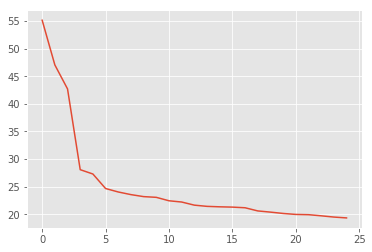

In [49]:
plt.plot(_)

In [68]:

res = []


x_curr = x_init

for t in tqdm(range(25)):

    res.append(F.f(x_curr))
    jrandom_key, subkey = jrandom.split(jrandom_key)
    S, _ = optimize_uncentered_S(F.f2(x_curr), sig, max_steps=10)
    sg = simplex_gradient(F, x_curr, S, subkey)
#     sg = F.f1(x_curr)
    
    search_direction = -sg

    alpha = linesearch(x_curr, search_direction)
    x_curr += alpha*search_direction    


100%|██████████| 25/25 [00:23<00:00,  1.17it/s]


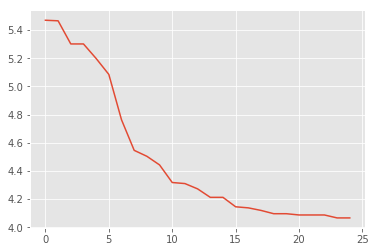

In [63]:
plt.plot(res)
# plt.yscale("log")




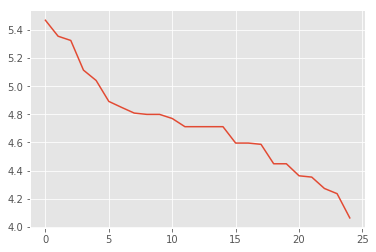

In [69]:
plt.plot(res)
# plt.yscale("log")



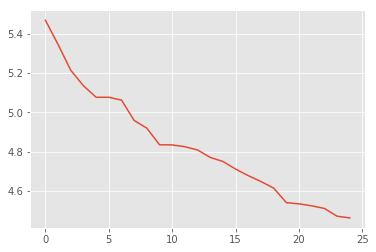

In [67]:
plt.plot(res)
# plt.yscale("log")


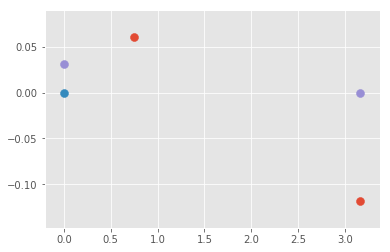

In [115]:
S = x_res
plt.scatter(S[0], S[1])
plt.scatter([0], [0])

x_init = jnp.diag(jnp.sqrt(sig / jnp.diag(H))).flatten()
S_init = x_init.reshape(dim, dim).T
plt.scatter(S_init[0], S_init[1])


plt.show()

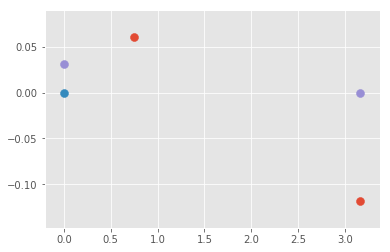

In [100]:
S = x_curr.reshape(dim, dim).T
plt.scatter(S[0], S[1])
plt.scatter([0], [0])

x_init = jnp.diag(jnp.sqrt(sig / jnp.diag(H))).flatten()
S_init = x_init.reshape(dim, dim).T
plt.scatter(S_init[0], S_init[1])


plt.show()

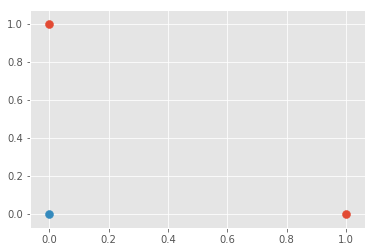

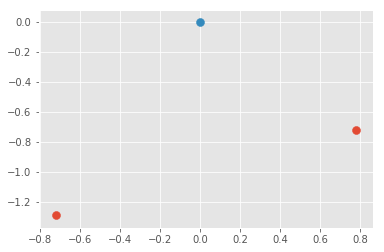

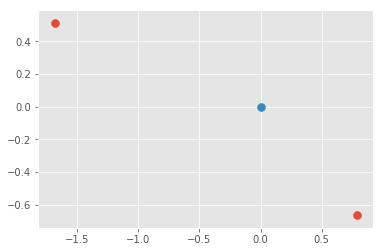

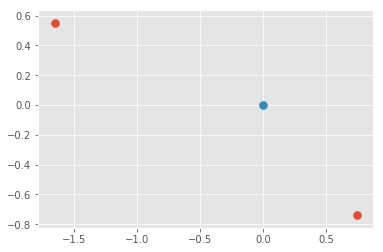

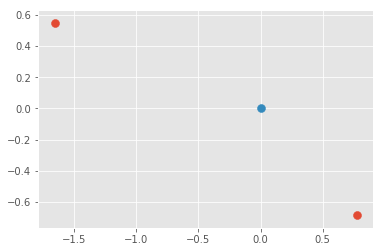

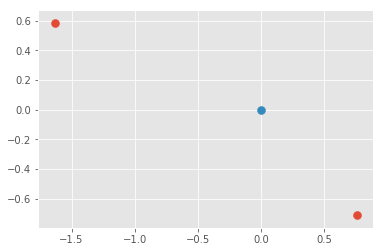

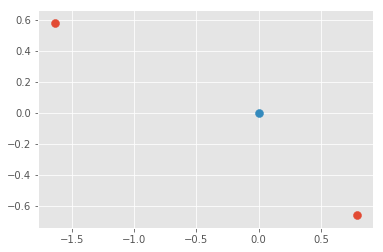

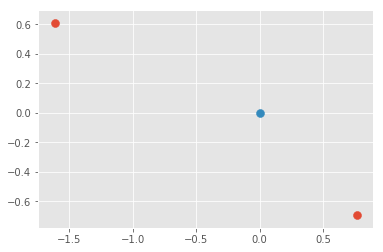

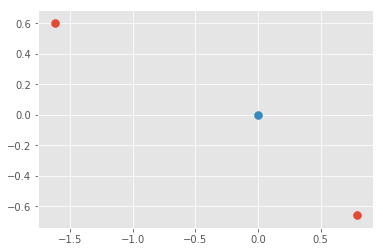

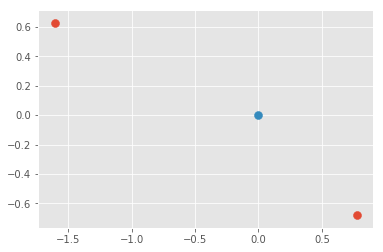

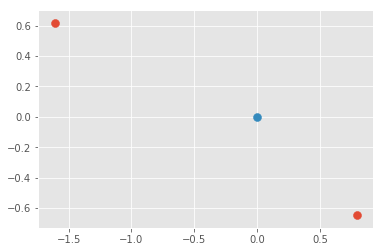

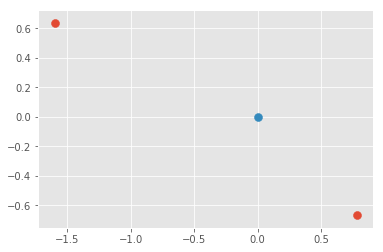

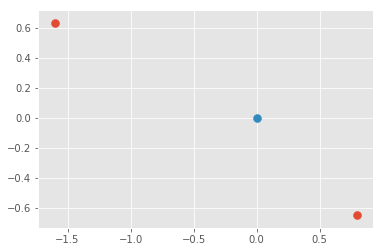

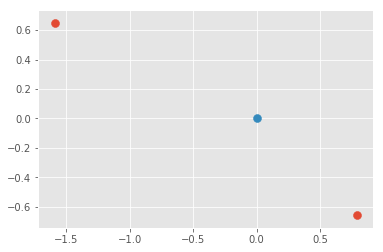

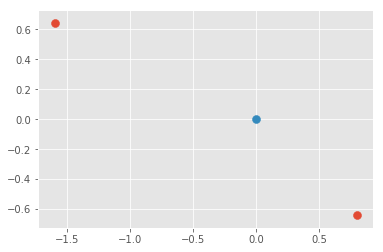

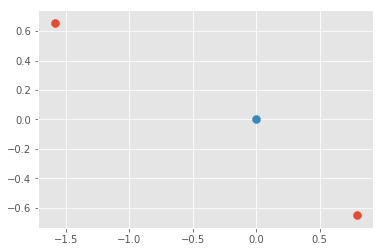

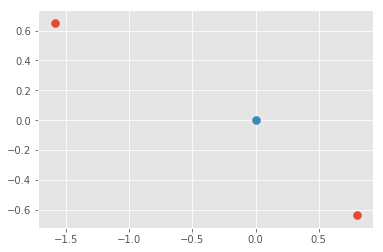

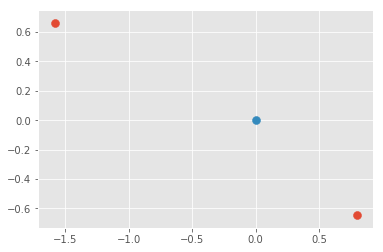

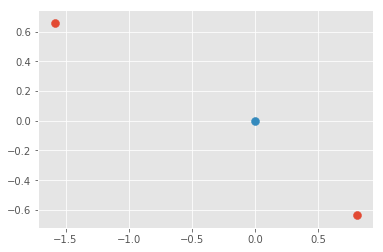

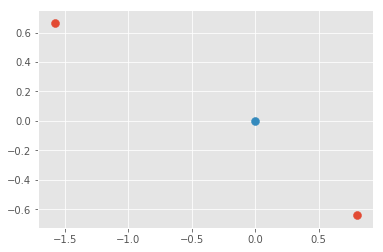

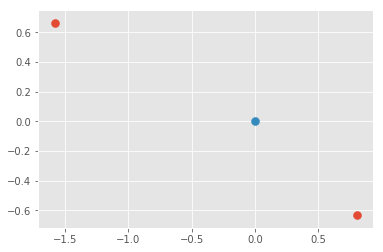

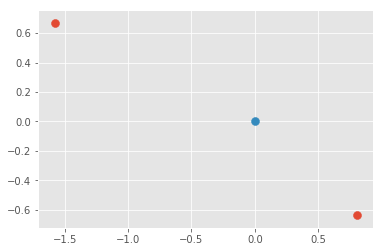

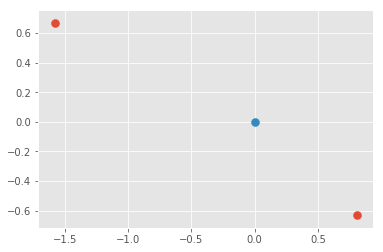

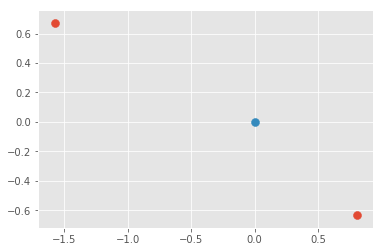

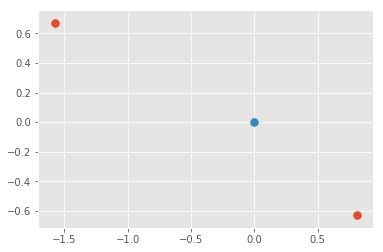

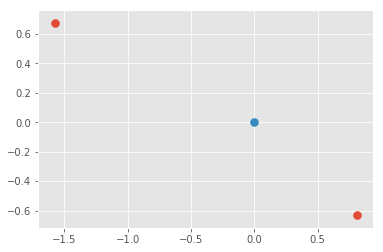

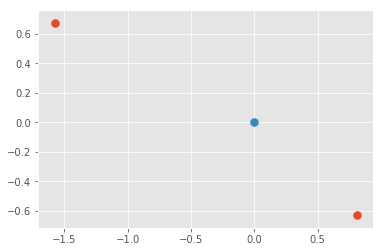

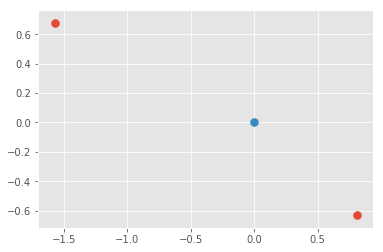

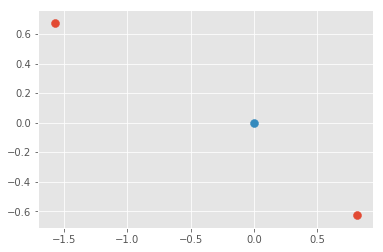

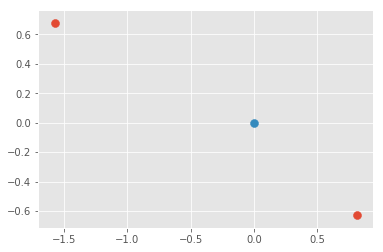

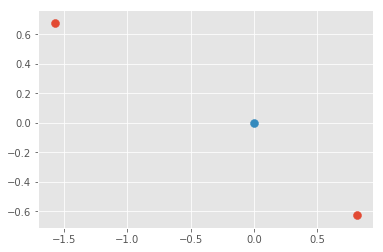

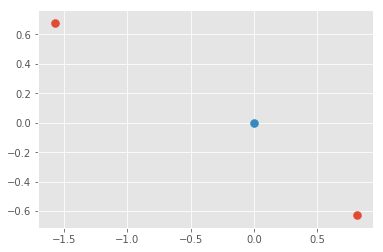

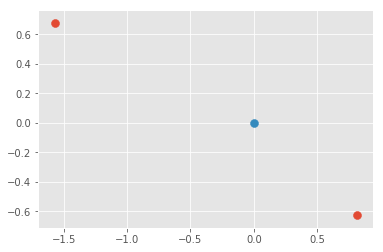

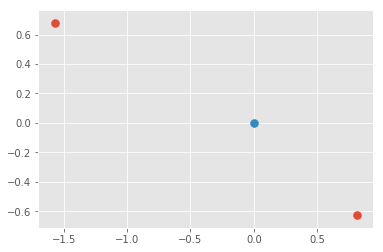

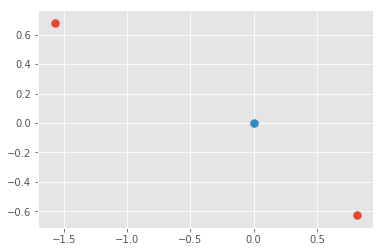

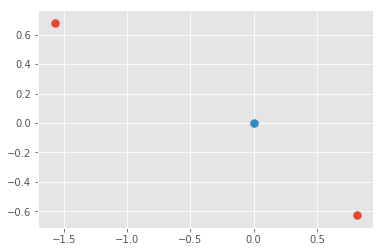

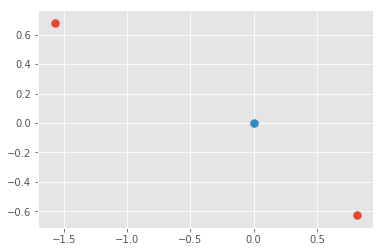

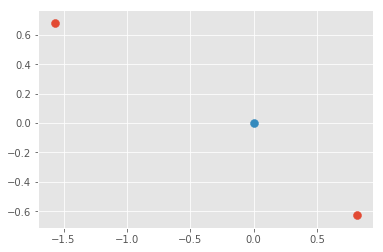

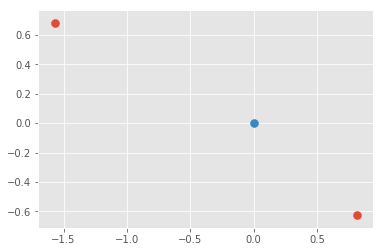

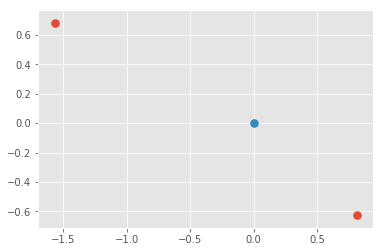

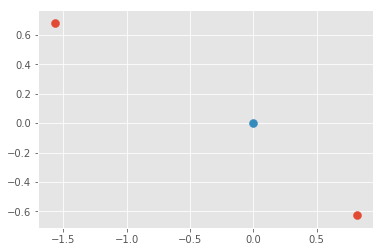

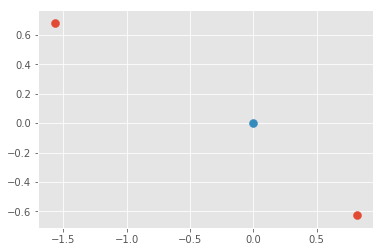

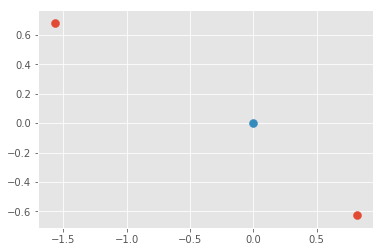

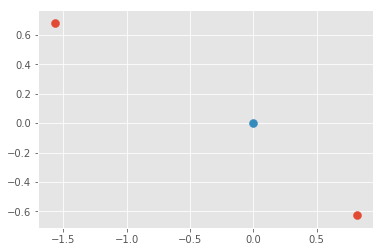

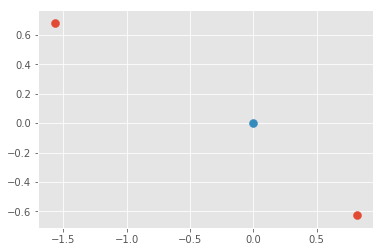

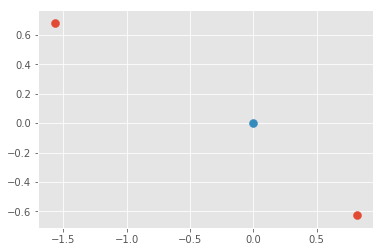

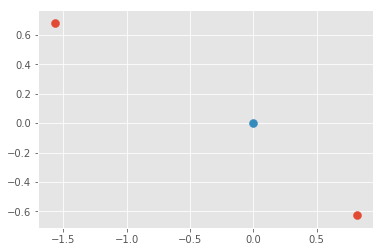

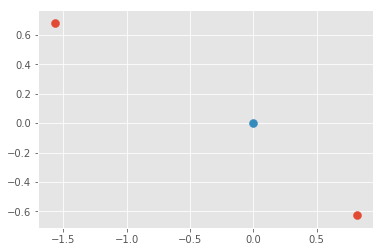

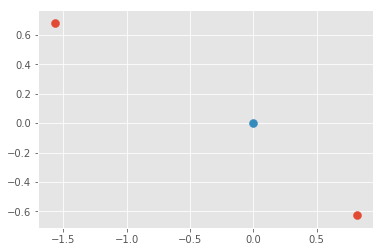

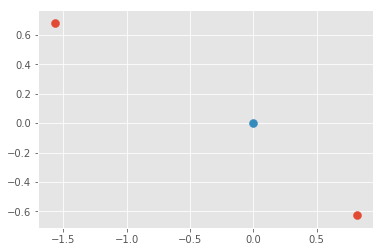

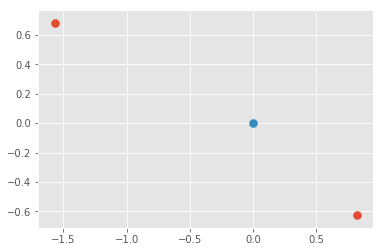

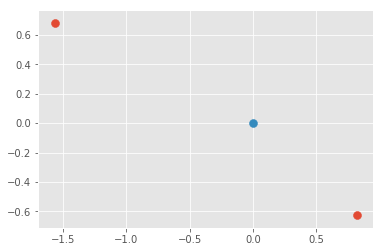

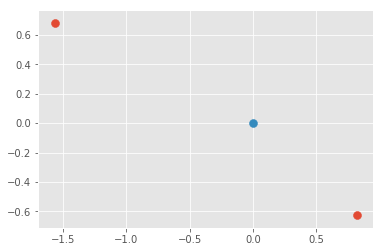

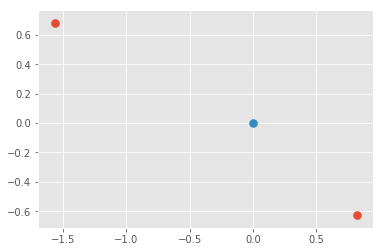

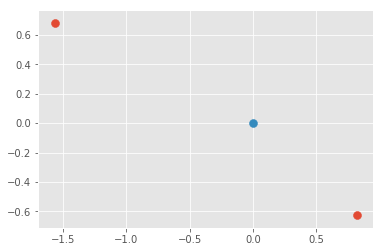

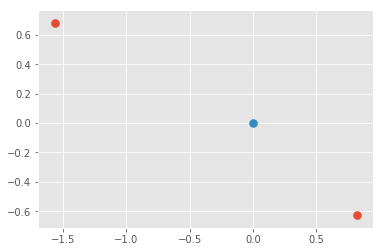

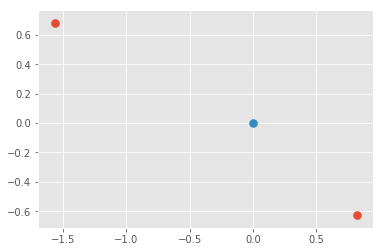

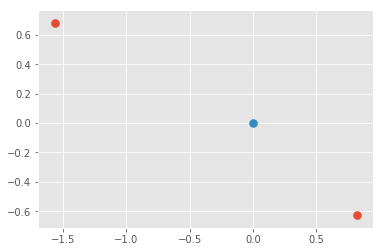

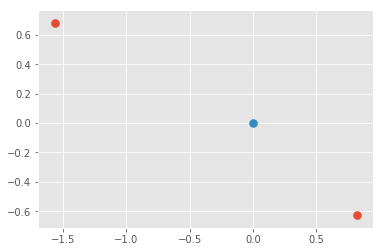

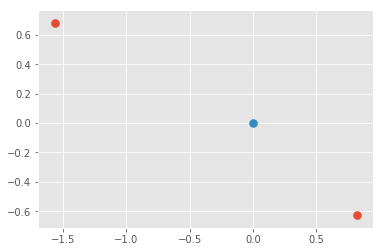

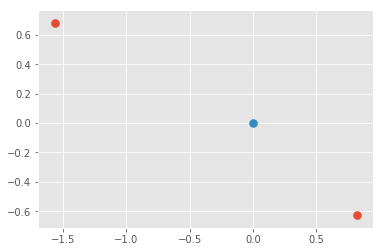

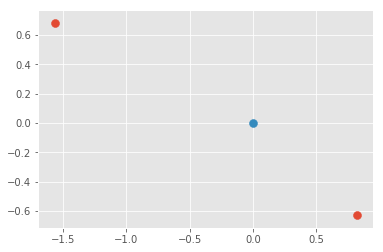

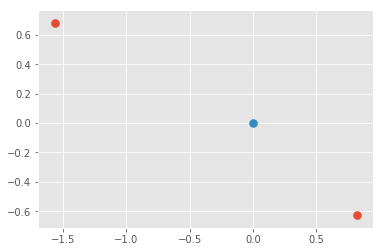

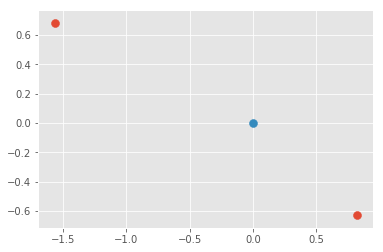

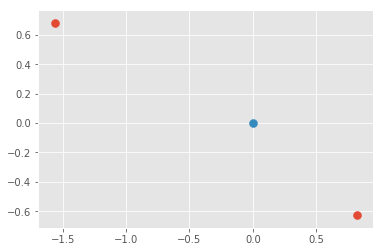

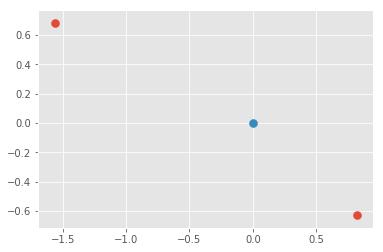

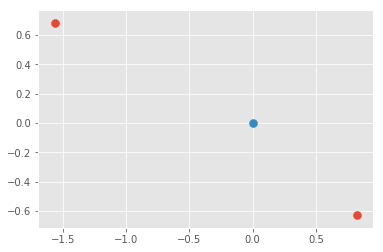

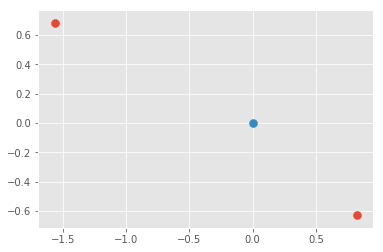

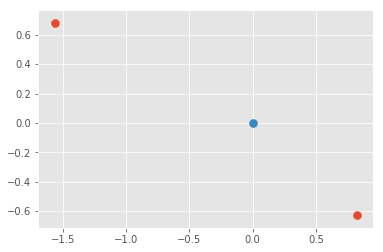

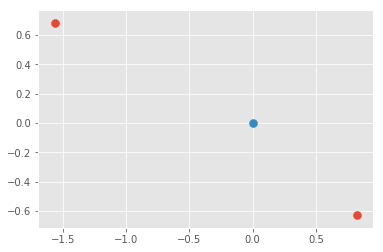

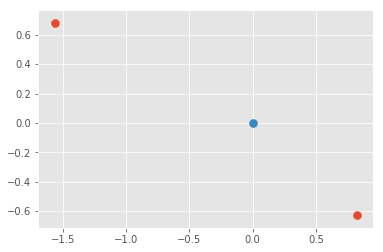

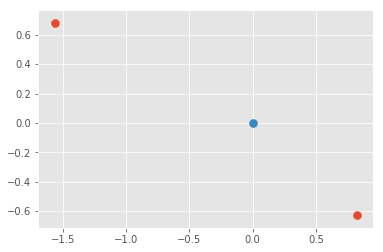

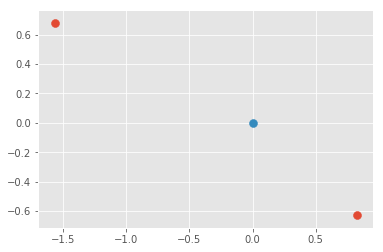

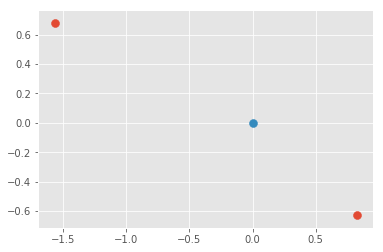

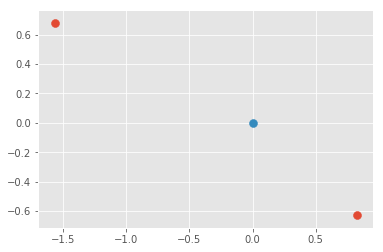

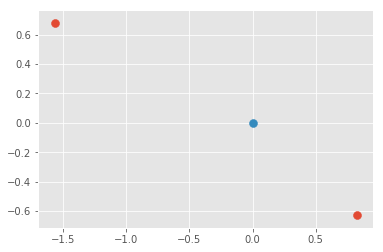

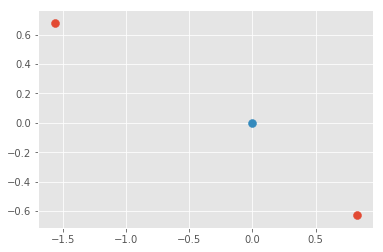

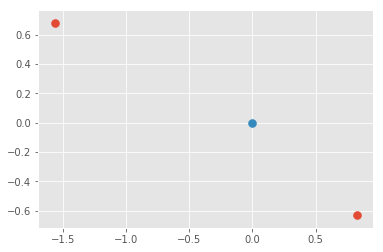

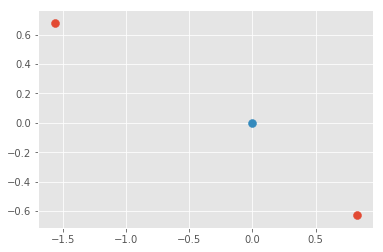

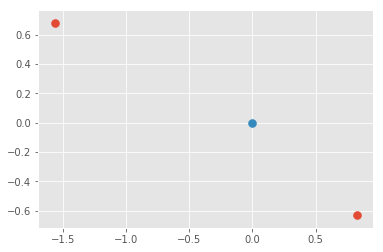

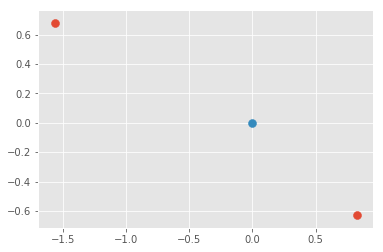

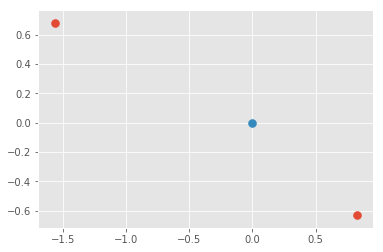

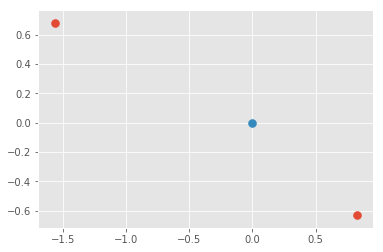

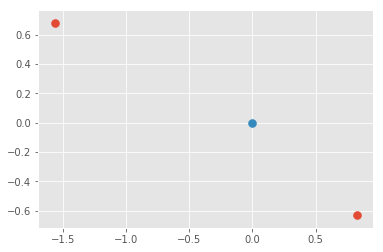

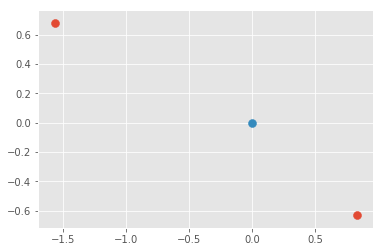

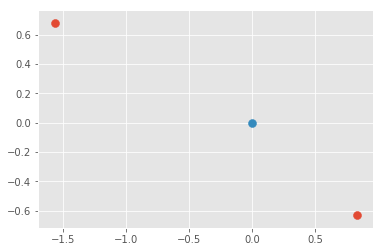

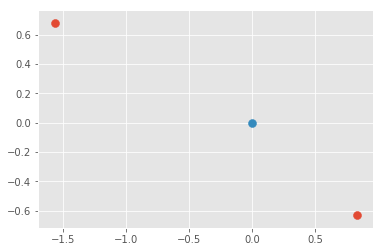

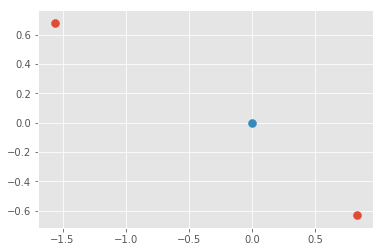

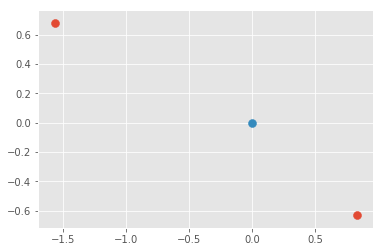

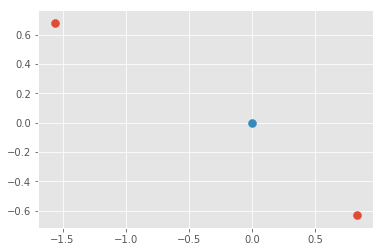

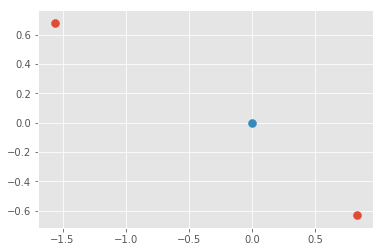

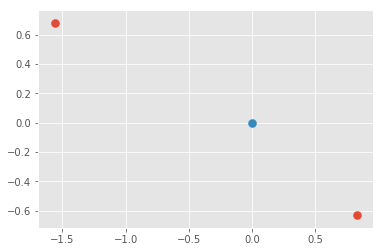

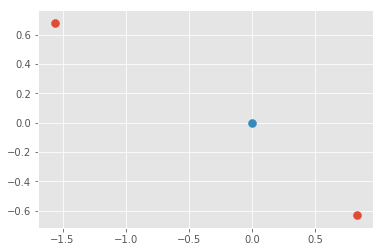

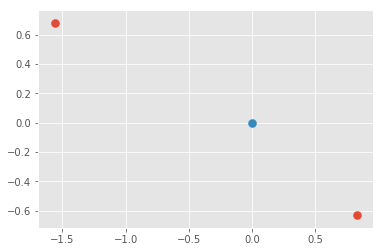

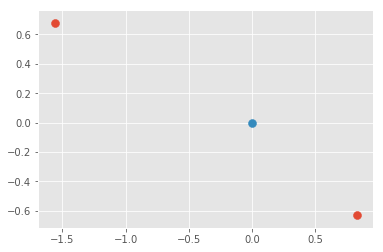

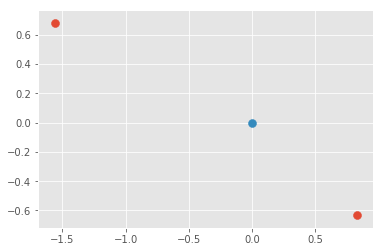

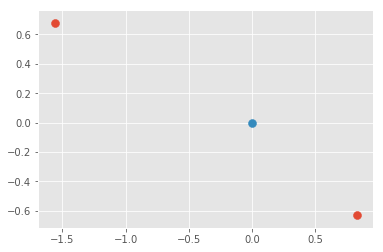

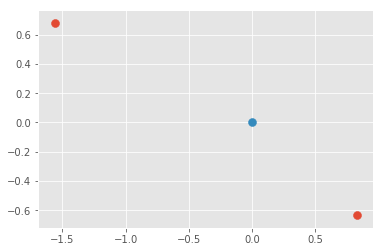

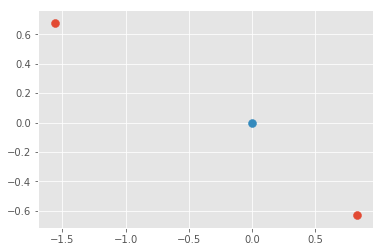

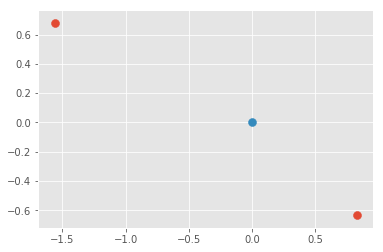

In [49]:
for r in res:
    S = r.reshape(N, dim).T
    plt.scatter(S[0], S[1])
    plt.scatter([0], [0])
    plt.show()

In [60]:
curr_grad = g_l(x_curr)
H_inv = jnp.linalg.inv(H(x_curr))
search_direction = -H_inv.dot(curr_grad)

In [61]:
jnp.linalg.eig(H(x_curr))

[DeviceArray([1685.63322606+0.j,  -84.61473158+0.j,   26.42629043+0.j,
                 3.8469354 +0.j], dtype=complex128),
 DeviceArray([[ 0.5251804 +0.j,  0.58383124+0.j,  0.47726384+0.j,
                0.39439302+0.j],
              [ 0.69837488+0.j,  0.10115261+0.j, -0.63865459+0.j,
               -0.30685662+0.j],
              [ 0.15504333+0.j, -0.04186867+0.j,  0.55505492+0.j,
               -0.81616335+0.j],
              [ 0.46089005+0.j, -0.80446022+0.j,  0.23717836+0.j,
                0.2901216 +0.j]], dtype=complex128)]

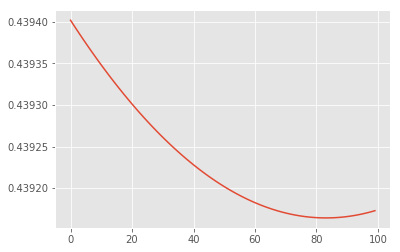

In [59]:
rr = []

curr_grad = g_l(x_curr)



for a in np.linspace(0, 0.002, 100):
    rr.append(l(x_curr - a*curr_grad))
    
plt.plot(rr)

In [18]:
print(counter)

100


(0, 10)

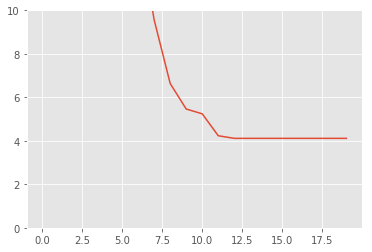

In [44]:
plt.plot(res)
plt.ylim(0, 10)

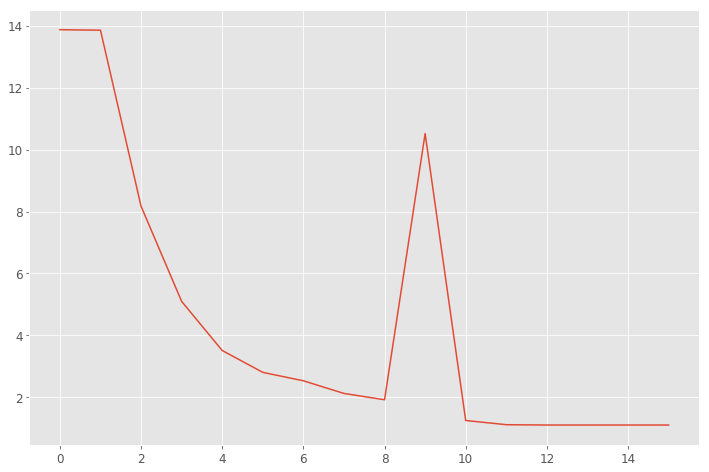

In [157]:
plt.plot(res)

In [40]:
# def helper_linesearch(f, g, c1, c2):

#     def helper(X, search_direction):
#         f0 = f(X)
#         f1 = search_direction # g(X)
#         dg = jnp.inner(search_direction, f1)

#         def armijo_rule(alpha):
#             return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
#         def armijo_update(alpha):
#             return c2*alpha
            
#         alpha = 1
#         while armijo_rule(alpha):
#             alpha = armijo_update(alpha)


#         return alpha

#     return helper

In [72]:
class Quadratic:
    def __init__(self, Q, b, sig=0):
        self.Q = Q
        self.b = b
        self.sig = sig
        self._f1 = grad(lambda x: self.f(x, None)[0])
        self._f2 = jacfwd(lambda x: self.f1(x))
        
        
    def f(self, X, jrandom_key=None):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        Y = jnp.dot(self.Q, X.T)
        Y = jnp.diag(jnp.dot(X, Y)) + X.dot(self.b) # TODO fix. inefficient way to remove x_j^T Q x_i for i != j. 
        Y += self.sig * np.random.normal(size=(X.shape[0], ))
        return Y
    
    def f1(self, X):
        return self._f1(X.reshape(1, -1))[0]
    
    def f2(self, X):
        return self._f2(X.reshape(1, -1)).reshape(X.size, X.size)


    


In [83]:
A.dot(X.T)

DeviceArray([[  1.        ],
             [  3.16227766],
             [ 10.        ],
             [ 31.6227766 ],
             [100.        ]], dtype=float64)

In [84]:
F = Quadratic(A, np.zeros(dim), sig)
X = np.ones(shape=(1, dim))
F.f2(X)


DeviceArray([[  2.        ,   0.        ,   0.        ,   0.        ,
                0.        ],
             [  0.        ,   6.32455532,   0.        ,   0.        ,
                0.        ],
             [  0.        ,   0.        ,  20.        ,   0.        ,
                0.        ],
             [  0.        ,   0.        ,   0.        ,  63.2455532 ,
                0.        ],
             [  0.        ,   0.        ,   0.        ,   0.        ,
              200.        ]], dtype=float64)

In [27]:
def simplex_gradient(F, x_0, S):

    FS = F.f(S.T + x_0)

    F_x_0 = F.f(x_0.reshape(1, -1))
    SS_inv = jnp.linalg.inv(S.dot(S.T))
    return SS_inv.dot(S.dot(FS - F_x_0))

In [38]:
F = Quadratic(A, np.zeros(dim), sig)

nn = 1000

x_0 = np.ones(dim)/np.linalg.norm(np.ones(dim))

curr_res = []

tg = F.f1(x_0.reshape(1, -1))[0]

S = np.array([3.16227766, 0.        , 0.        , 0.        , 0.        ,
             0.        , 1.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.31622777, 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.1       , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.03162278]).reshape(N, dim).T

S = np.array([-0.90493691,  1.53902761,  1.40497385, -0.24473887,
              0.0690785 , -2.71994924, -1.88153505,  1.18396365,
              0.49406998, -0.00506956, -3.08113441, -0.60576899,
             -1.34979995,  0.34908746,  0.16662678, -1.97387752,
              1.98359131, -0.98968602,  0.67665327, -0.05326298,
             -0.62092527,  2.25068533,  0.01697502,  0.55142443,
              0.04223838]).reshape(N, dim).T

S = np.array([ 3.16228238e+00, -5.28872076e-06, -6.59325149e-05,
             -1.00031227e-04, -5.15238072e-04, -1.21404358e-05,
              1.00013294e+00, -6.86895367e-04, -9.27574091e-04,
             -5.86367998e-03,  1.63421257e-04,  2.48808624e-04,
              3.12718300e-01,  6.45874094e-03, -5.11739178e-02,
              3.01726739e-03,  8.33810548e-03,  2.26390043e-02,
              1.12710106e-01, -2.07910457e-02,  4.71994537e-03,
              1.64906710e-02,  1.17775069e-01,  7.65107316e-02,
              4.18077383e-02]).reshape(N, dim).T

S = np.array([ 3.16228252e+00, -5.56423334e-06, -6.92258194e-05,
             -1.02784007e-04, -5.30918567e-04, -1.27041668e-05,
              1.00013603e+00, -7.20495391e-04, -9.49475843e-04,
             -6.05627146e-03,  1.70833793e-04,  2.54703976e-04,
              3.12557537e-01,  6.85220815e-03, -5.15833708e-02,
              3.06161826e-03,  8.44558991e-03,  2.37489626e-02,
              1.12797481e-01, -2.04829137e-02,  4.78893926e-03,
              1.67754585e-02,  1.20495734e-01,  7.51761443e-02,
              4.17314132e-02]).reshape(N, dim).T

for _ in tqdm(range(nn)):
    sg = simplex_gradient(F, x_0, S)
    curr_res.append(np.linalg.norm(sg - tg)**2)
    
    


100%|██████████| 1000/1000 [00:05<00:00, 174.42it/s]


In [29]:
np.mean(curr_res)

6.256679277274481

In [30]:
np.std(curr_res)

1.0664008918209462

In [32]:
np.mean(curr_res)

7.613789932810005

In [33]:
np.std(curr_res)

6.093230391589686

In [39]:
np.mean(curr_res)

7.6532599262818115

In [40]:
np.std(curr_res)

5.87352938884101

In [115]:
np.linalg.norm(sg - tg)**2

9.79182184631405

In [94]:
sg

DeviceArray([7.36300268e-03, 3.33828963e-01, 1.41061750e+00,
             1.06513682e+01, 9.34393217e+01], dtype=float64)

In [101]:
np.std(curr_res)

48.95407970171319

In [103]:
np.std(curr_res)

40.49284797229163

In [114]:
sg

DeviceArray([1.17568774e-01, 3.40980911e-02, 1.66656686e+00,
             1.01608199e+01, 8.66676928e+01], dtype=float64)